In [1]:
# Import Optimization Libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# Import General Libraries
import sympy as sym
import numpy as np
from IPython.display import display 

# Create a Concrete Model
model = ConcreteModel()

In [2]:
Nodes = 100
model.Nodes = range(0,Nodes)

In [3]:
model.X0 = Param(initialize = 0.0) # position of fixed base
model.Y0 = Param(initialize = 0.0)
model.h = Param(initialize = 0.02) # time step

model.Damping = Param(initialize = 0.7)  # Damping coefficient
model.mass = Param(initialize = 1.0) # mass of the 'mass'

# Initailize Position, Velocity and Acceleration
model.x1 = Var(model.Nodes)
model.dx1 = Var(model.Nodes)
model.ddx1 = Var(model.Nodes)

#model.Force = Var(model.Nodes)

# Define Contact Force
model.CF_ext = Var(model.Nodes)
model.CF_rtn = Var(model.Nodes)
model.L_max = Param(initialize = 4)
model.L_min = Param(initialize = 0)
model.eps = Param(initialize = 1000.0, mutable = True)

###########################################################################################
model.CF_pos = Var(model.Nodes) # new
model.CF_neg = Var(model.Nodes) # new

In [4]:
# Intergration Constraints
def BwEuler_p(model,n): # Positions
    if n > 1:
        return model.x1[n] == model.x1[n-1] + model.h*model.dx1[n-1]
    else:
        return Constraint.Skip # Leaves out members of a set that the constraint doesn't apply to
model.integrate_p = Constraint(model.Nodes, rule = BwEuler_p)

def BwEuler_v(model,n): # Velocities
    if n > 1:
        return model.dx1[n] == model.dx1[n-1] + model.h*model.ddx1[n-1]
    else:
        return Constraint.Skip 
model.integrate_v = Constraint(model.Nodes, rule = BwEuler_v)

In [5]:
X0 = sym.symbols('X0')   #starting position of the block
m1 = sym.symbols('m1')   #mass of the block
b1 = sym.symbols('b1')   #damping coefficient

L_max = sym.symbols('L_max')  # Max stroke length
L_min = sym.symbols('L_min')  # Min stroke length

x1 = sym.symbols('x1')                #position of the block
dx1 = sym.symbols('\dot{\\ x}_{1}')    #velocity of the block
ddx1 = sym.symbols('\ddot{\\ x}_{1}')  #acceleration of the block

q = sym.Matrix([x1])
dq = sym.Matrix([dx1])
ddq = sym.Matrix([ddx1])

Xnew = X0 + x1

p1 = sym.Matrix([Xnew, x1])
[dXnew, dx1] = p1.jacobian(q)*dq
#display(p1)             # [original position + current position ; current position]

# Just checking
dp1 = sym.Matrix([dXnew, dx1]) # --> derivative of the p1 matrix
#display(dp1)

######################################################################################################################
######################################################################################################################

#Define kinetic and potential energies for use in Lagrangian
T = sym.Matrix([0.5*m1*(dXnew**2)])
V = sym.Matrix([0]) 

# Define damping
Damp = sym.Matrix([b1*dx1])
#display(Damp)

#Calculate terms of the Lagrangian Equation
Lg1 = sym.zeros(1,len(q))
for i in range(len(q)):
    dT_ddq = sym.diff(T,dq[i]) 
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq 

Lg3 = T.jacobian(q)

Lg4 = V.jacobian(q) 

#apply a horizontal force
F = sym.symbols('F')                  #applied force parameter
FF = sym.Matrix([[F],[0],[0]])        #force matrix
rF = sym.Matrix([[X0 + Xnew],[0],[0]])  #distance the force acts on the block
JF = rF.jacobian(q)
QF = JF.transpose()*FF
#display(QF)
Force = QF

# Complimentarity Forces
F_ext = sym.symbols('F_ext')
Extention = sym.Matrix([F_ext])
F_rtn = sym.symbols('F_rtn')
Retraction = sym.Matrix([F_rtn])

############################### NEW STUFF #######################
F_pos = sym.symbols('F_pos')
Fpositive = sym.Matrix([F_pos])
F_neg = sym.symbols('F_neg')
Fnegative = sym.Matrix([F_neg])
##################################################################

#Equation of motion
EOM = Lg1 - Lg3 + Lg4 - Damp + Retraction - Extention + Fpositive - Fnegative #- Force.transpose()
display(EOM)

Matrix([[-F_ext - F_neg + F_pos + F_rtn + 1.0*\ddot{ x}_{1}*m1 - \dot{ x}_{1}*b1]])

In [6]:
# Lambdify the EOM
func_map = {'sin':sin, 'cos':cos}  
sym_list = [X0, x1, dx1, ddx1, m1, b1, F_ext, F_rtn, F_pos, F_neg]

lambEOM1 = sym.lambdify(sym_list, EOM[0], modules = [func_map])

#display(lambEOM1)

# Create EOM Constraints
def EOM1(model,n): 
    # list the model versions of all quantities in the same order as sym_list
    var_list = [model.X0, model.x1[n], model.dx1[n], model.ddx1[n], model.mass, model.Damping, model.CF_ext[n], 
               model.CF_rtn[n], model.CF_pos[n], model.CF_neg[n]] 
    return lambEOM1(*var_list) == 0
model.EOM = Constraint(model.Nodes, rule = EOM1)

In [7]:
# Define Cost Function - minimizing force
#def CostFunction(model):
#    sum_force = 0
#    for n in range(1,Nodes):
#            sum_force = sum_force + model.Force[n]**2 
#    return sum_force
#
#model.Cost = Objective(rule = CostFunction)

In [8]:
# Cost Function - minimizing time
def CostFunction(model):
    sum_time = 0
    for n in range(1,Nodes):
        sum_time = sum_time + model.h
    return sum_time
model.Cost = Objective(rule = CostFunction)

In [9]:
# Define Variable Bounds
for n in range(1,Nodes):
    #model.Force[n].setlb(-40)
    #model.Force[n].setub(40)
    model.x1[n].setlb(0)
    model.x1[n].setub(4)
    # Hard stops
    model.CF_ext[n].setlb(0)
    model.CF_ext[n].setub(1500)
    model.CF_rtn[n].setlb(0)
    model.CF_rtn[n].setub(1500)
    
    ############################### NEW STUFF ####################
    model.CF_pos[n].setlb(0)
    model.CF_pos[n].setub(1000)
    model.CF_neg[n].setlb(0)
    model.CF_neg[n].setub(1000)
    ###############################################################

In [10]:
# Initialization of variables
for n in range (1,Nodes):
    #model.Force[n].value = 0.01
    model.CF_ext[n].value = 0.01
    model.CF_rtn[n].value = 0.01
    
    ########################### NEW STUFF #########################
    model.CF_pos[n].value = 0
    model.CF_neg[n].value = 0
    ###############################################################
    
    model.x1[n].value = np.random.uniform(0,4)
    model.dx1[n].value = 0.01
    model.ddx1[n].value = 0.01

In [11]:
# Set Boundary Conditions
# Initial Conditions
model.x1[1].fixed = True
model.x1[1].value = 1

model.dx1[1].fixed = True
model.dx1[1].value = 0

# Final Conditions
# Nodes-1 ensures it stops at 99, if you just say Nodes jupyter throughs a tantrum
model.x1[Nodes-1].fixed = True 
model.x1[Nodes-1].value = 4   # Stop at specified location 

model.dx1[Nodes-1].fixed = True
model.dx1[Nodes-1].value = 0

In [12]:
# Start the Solver
model.eps.value = 1000.0
   
for i in range (0,8):
    print(model.eps.value)
        
    def extension_contact(model,n):
        alpha_ext = model.L_max - model.x1[n]
        beta_ext = model.CF_ext[n]
        return alpha_ext*beta_ext <= model.eps
    model.extension_contact = Constraint(model.Nodes, rule = extension_contact)
    
    
    def retraction_contact(model,n):
        alpha_rtn = model.x1[n] - model.L_min
        beta_rtn = model.CF_rtn[n]
        return alpha_rtn*beta_rtn <= model.eps
    model.retraction_contact = Constraint(model.Nodes, rule = retraction_contact)
    
    ########################## NEW STUFF #################################
    def pos_Slack(model,n):
        alpha_pos = (100 - model.CF_pos[n])
        beta_pos = model.CF_pos[n]
        return alpha_pos*beta_pos <= model.eps
    model.pos_Slack = Constraint(model.Nodes, rule = pos_Slack)
    
    def neg_Slack(model,n):
        alpha_neg = (100 - model.CF_neg[n])
        beta_neg = model.CF_neg[n]
        return alpha_neg*beta_neg <= model.eps
    model.neg_Slack = Constraint(model.Nodes, rule = neg_Slack)
    
    #def bang_bang(model,n):
    #    bang_bang_Force = model.CF_pos[n] - model.CF_neg[n] + model.CF_ext[n] + model.CF_rtn[n]
    #    return bang_bang_Force <= model.eps
    #model.bang_bang = Constraint(model.Nodes, rule = bang_bang)
    ######################################################################
        
    optimize = SolverFactory('ipopt')
    
    optimize.options["print_level"] = 5
    optimize.options["max_iter"] = 30000
    optimize.options["max_cpu_time"] = 600
    optimize.options["Tol"] = 1e-6

    results = optimize.solve(model, tee = True) 
    model.eps.value = model.eps.value/10
    
   # model.del_component(model.extension_contact)
    model.del_component(model.extension_contact_index)
   # model.add_component("extension_contact",Constraint(model.Nodes, rule = extension_contact))
    
  #  model.del_component(model.retraction_contact)
    model.del_component(model.retraction_contact_index)
  #  model.add_component("retraction_contact",Constraint(model.Nodes,rule = retraction_contact))
    model.del_component(model.pos_Slack_index)
    model.del_component(model.neg_Slack_index)
  #  model.del_component(model.bang_bang_index)

1000.0
Ipopt 3.11.1: print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     1181
Number of nonzeros in inequality constraint Jacobian.:      595
Number of nonzeros in Lagrangian Hessian.............:      396

Total number of variables............................:      696
                     variables with only lower bounds:        0
 

10.0
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new

  72 1.9800000e+000 7.95e-002 2.66e+007  -1.0 9.00e+002   2.3 1.08e-002 2.10e-004h  1
  73 1.9800000e+000 7.95e-002 2.59e+009  -1.0 2.24e+001   1.8 5.72e-001 8.59e-004h  1
  74 1.9800000e+000 7.91e-002 5.76e+011  -1.0 1.39e+001   1.3 1.00e+000 4.42e-003h  1
  75 1.9800000e+000 7.91e-002 2.15e+014  -1.0 2.22e+002   0.8 3.90e-002 1.04e-004h  1
  76 1.9800000e+000 7.91e-002 1.58e+012  -1.0 2.50e-006  12.7 9.93e-001 1.00e+000h  1
  77r1.9800000e+000 7.91e-002 1.00e+003  -1.0 0.00e+000  12.2 0.00e+000 3.39e-007R  2
  78r1.9800000e+000 8.18e-002 8.90e+002  -1.0 1.03e+001    -  2.38e-001 1.09e-001f  1
  79r1.9800000e+000 1.22e-001 4.16e+002  -1.0 1.31e+001    -  9.88e-001 5.33e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r1.9800000e+000 1.22e-001 3.13e+002  -1.0 9.34e+001    -  8.59e-001 2.46e-001f  1
  81r1.9800000e+000 1.25e-001 4.63e+001  -1.0 1.76e+001    -  6.63e-001 1.00e+000f  1
  82r1.9800000e+000 1.32e-001 1.12e+001  -1.0 6.13e+000    

  24r1.9800000e+000 8.79e+000 9.99e+002   0.9 0.00e+000   0.8 0.00e+000 4.50e-007R  5
  25r1.9800000e+000 8.47e+000 9.99e+002   0.9 8.61e+003    -  4.67e-004 3.20e-004f  1
  26r1.9800000e+000 5.78e+000 9.98e+002   0.9 4.11e+003    -  4.37e-004 1.46e-003f  1
  27 1.9800000e+000 5.77e+000 1.90e+002  -1.0 1.58e+002    -  1.84e-003 1.00e-005h  1
  28 1.9800000e+000 5.77e+000 5.23e+002  -1.0 3.23e+001   0.3 5.84e-003 1.48e-003h  1
  29r1.9800000e+000 5.77e+000 9.99e+002   0.8 0.00e+000    -  0.00e+000 4.17e-007R  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r1.9800000e+000 5.53e+000 1.00e+003   0.8 1.55e+003    -  3.53e-003 1.86e-004f  1
  31r1.9800000e+000 4.70e+000 9.99e+002   0.8 1.01e+003    -  4.04e-003 9.73e-004f  1
  32 1.9800000e+000 4.70e+000 3.30e+001  -1.0 4.68e+001  -0.2 6.86e-004 2.41e-005h  1
  33 1.9800000e+000 4.70e+000 1.25e+001  -1.0 6.82e+001  -0.7 7.25e-005 3.44e-004h  1
  34r1.9800000e+000 4.70e+000 9.99e+002   0.7 0.00e+000  -1

Ipopt 3.11.1: print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     1181
Number of nonzeros in inequality constraint Jacobian.:      595
Number of nonzeros in Lagrangian Hessian.............:      396

Total number of variables............................:      696
                     variables with only lower bounds:        0
        

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
0.01
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, u

  56 1.9800000e+000 1.07e+000 4.57e+002  -1.0 1.48e+003 -16.6 4.08e-005 1.45e-005h  1
  57 1.9800000e+000 1.07e+000 6.51e+002  -1.0 2.05e+003 -17.1 3.05e-005 1.08e-005h  1
  58 1.9800000e+000 1.07e+000 9.53e+002  -1.0 1.07e+001 -16.6 6.33e-003 2.04e-003h  1
  59 1.9800000e+000 1.06e+000 1.21e+003  -1.0 7.07e+000 -17.1 8.03e-003 4.30e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.9800000e+000 1.06e+000 1.71e+003  -1.0 4.12e+000 -16.7 1.43e-002 7.06e-003h  1
  61 1.9800000e+000 1.03e+000 1.99e+003  -1.0 1.57e+000 -16.3 2.86e-002 2.42e-002h  1
  62r1.9800000e+000 1.03e+000 1.00e+003   0.0 0.00e+000 -15.8 0.00e+000 2.77e-007R  5
  63r1.9800000e+000 1.03e+000 7.44e+003   0.0 8.24e+000    -  9.90e-001 9.19e-003f  1
  64r1.9800000e+000 7.26e-001 6.18e+003   0.0 5.37e+001    -  1.00e+000 4.29e-001f  1
  65 1.9800000e+000 7.26e-001 3.51e+000  -1.0 6.29e+000 -16.3 2.08e-003 8.33e-004h  1
  66 1.9800000e+000 7.25e-001 6.98e+000  -1.0 4.92e+000 -15

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
0.001
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, 

  63 1.9800000e+000 2.96e+000 1.65e+001  -1.0 2.09e+003 -16.9 1.16e-004 2.09e-004h  1
  64 1.9800000e+000 2.96e+000 1.11e+001  -1.0 3.71e+003 -17.4 1.75e-004 8.44e-005h  1
  65 1.9800000e+000 2.96e+000 1.77e+001  -1.0 2.51e+003 -17.0 9.91e-005 2.02e-004h  1
  66 1.9800000e+000 2.96e+000 1.03e+001  -1.0 2.39e+003 -17.4 2.15e-004 9.92e-005h  1
  67 1.9800000e+000 2.96e+000 1.75e+001  -1.0 3.46e+003 -17.0 8.17e-005 1.92e-004h  1
  68 1.9800000e+000 2.96e+000 9.67e+000  -1.0 1.94e+003 -17.5 3.64e-004 1.06e-004h  1
  69 1.9800000e+000 2.96e+000 5.93e+000  -1.0 6.03e+003    -  3.73e-005 1.28e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.9800000e+000 2.96e+000 1.39e+001  -1.0 1.78e+003 -17.1 2.53e-004 7.51e-005h  1
  71 1.9800000e+000 2.95e+000 6.83e+000  -1.0 6.01e+003 -17.5 2.72e-005 1.38e-004h  1
  72 1.9800000e+000 2.95e+000 2.62e+001  -1.0 2.69e+002 -17.1 3.60e-004 8.32e-005h  1
  73 1.9800000e+000 2.95e+000 1.63e+001  -1.0 4.61e+003 -16

 168r1.9800000e+000 2.56e+000 4.37e-001  -5.5 2.51e-001  -2.1 1.00e+000 1.00e+000h  1
 169r1.9800000e+000 2.68e+000 1.48e-001  -5.5 1.22e-001  -1.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r1.9800000e+000 3.00e+000 6.40e+000  -5.5 1.02e+000  -2.2 1.00e+000 3.14e-001f  1
 171r1.9800000e+000 2.99e+000 9.10e-001  -5.5 8.32e-002    -  1.00e+000 1.25e-001f  4
 172r1.9800000e+000 3.00e+000 1.49e-001  -5.5 1.22e-002    -  1.00e+000 8.62e-001h  1
 173r1.9800000e+000 3.00e+000 3.01e-005  -5.5 2.42e-004    -  1.00e+000 1.00e+000f  1
 174r1.9800000e+000 3.00e+000 1.02e-001  -7.0 1.51e-003    -  8.51e-001 1.00e+000f  1
 175r1.9800000e+000 3.00e+000 5.28e-003  -7.0 2.53e-004    -  9.48e-001 1.00e+000h  1

Number of Iterations....: 175

                                   (scaled)                 (unscaled)
Objective...............:  1.9800000000000013e+000   1.9800000000000013e+000
Dual infeasibility......:  2.2559384816108955e-004 

  42 1.9800000e+000 2.97e+000 7.06e+000  -1.0 5.00e+003 -17.1 7.77e-005 9.08e-005h  1
  43 1.9800000e+000 2.97e+000 7.39e+000  -1.0 5.15e+003 -16.7 9.26e-005 1.00e-004h  1
  44 1.9800000e+000 2.97e+000 8.98e+000  -1.0 4.93e+003 -16.3 8.31e-005 1.18e-004h  1
  45 1.9800000e+000 2.97e+000 8.96e+000  -1.0 1.22e+004 -16.8 3.28e-005 3.27e-005h  1
  46 1.9800000e+000 2.97e+000 8.47e+000  -1.0 3.02e+003 -16.3 1.05e-004 9.48e-005h  1
  47 1.9800000e+000 2.97e+000 8.53e+000  -1.0 4.38e+003 -16.8 8.75e-005 8.90e-005h  1
  48 1.9800000e+000 2.97e+000 9.23e+000  -1.0 5.07e+003 -16.4 9.04e-005 1.05e-004h  1
  49 1.9800000e+000 2.97e+000 1.13e+001  -1.0 3.98e+003 -16.0 9.06e-005 1.29e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 1.9800000e+000 2.97e+000 9.90e+000  -1.0 3.87e+003 -16.4 1.14e-004 8.75e-005h  1
  51 1.9800000e+000 2.97e+000 8.17e+000  -1.0 4.79e+003 -16.0 1.26e-004 9.14e-005h  1
  52 1.9800000e+000 2.97e+000 1.02e+001  -1.0 1.89e+004    

    model=unknown;
        message from solver=Ipopt 3.11.1\x3a Converged to a locally infeasible
        point. Problem may be infeasible.


In [13]:
# Some debugging stuff
print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.
#model.pprint()

warning
infeasible


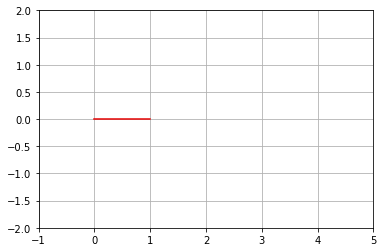

In [14]:
#animate model --> will be able to see what model is doing by viewing in with HTML
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1)
def plot_block(i,model,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,5])
    ax.set_ylim([-2,2])
    
    #plot mass
    m1topx = model.X0.value   #initial position of mass
    m1bottomx = m1topx + model.x1[i].value
    ax.plot([m1bottomx,0],[m1topx,0],color = 'xkcd:red')
    ax.grid(True)
    
update = lambda i: plot_block(i,model,ax1)      #lambdify just used to calculate the numerical values fast

animate = ani.FuncAnimation(fig1,update,range(1,Nodes),interval = 50, repeat = True)

HTML(animate.to_html5_video())

In [15]:
# Applied Force
#plt.axes()
#Time = 0
#for n in range(1,Nodes):
#    force = model.Force[n].value
#    time = model.h.value
#    Time += time
    #print(Time)
    #print(force)
#    plt.plot(Time,force,'y.')
#    plt.xlabel('Time')
#    plt.ylabel('Applied Force')
#    plt.title('Applied Force vs Time')

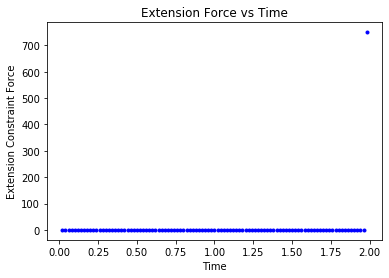

In [16]:
# Extension Constraint Force
plt.axes()
Time = 0
for n in range(1,Nodes):
    ext_force = model.CF_ext[n].value
    time = model.h.value
    Time += time
    
    plt.plot(Time,ext_force,'b.')
    plt.xlabel('Time')
    plt.ylabel('Extension Constraint Force')
    plt.title('Extension Force vs Time')

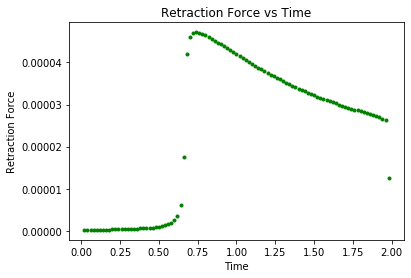

In [17]:
#Retraction Constraint Force  
plt.axes()  
Time = 0
for n in range(1,Nodes):
    rtn_force = model.CF_rtn[n].value
    time = model.h.value
    Time += time
    
    plt.plot(Time,rtn_force, 'g.')
    plt.xlabel('Time')
    plt.ylabel('Retraction Force')
    plt.title('Retraction Force vs Time')

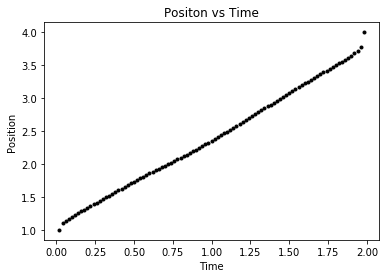

In [18]:
# Position vs Time
plt.axes()
Time = 0    
for n in range(1,Nodes):
    position = model.x1[n].value
    time = model.h.value
    Time += time
    
    plt.plot(Time,position,'k.')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title('Positon vs Time')

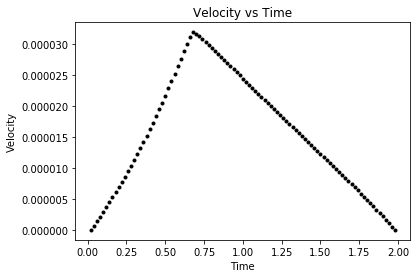

In [19]:
#Velocity vs Time
plt.axes()
Time = 0
for n in range(1,Nodes):
    velocity = model.dx1[n].value
    time = model.h.value
    Time += time
    
    plt.plot(Time,velocity,'k.')
    plt.xlabel('Time')
    plt.ylabel('Velocity')
    plt.title('Velocity vs Time')

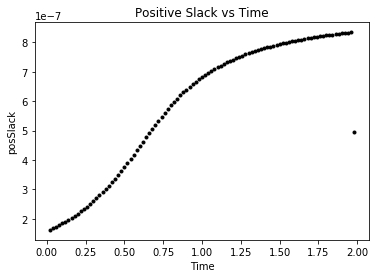

In [20]:
# Positive Slack
plt.axes()
Time = 0
for n in range (1,Nodes):
    posSlack = model.CF_pos[n].value
    time = model.h.value
    Time += time
    
    plt.plot(Time,posSlack,'k.')
    plt.xlabel('Time')
    plt.ylabel('posSlack')
    plt.title('Positive Slack vs Time')

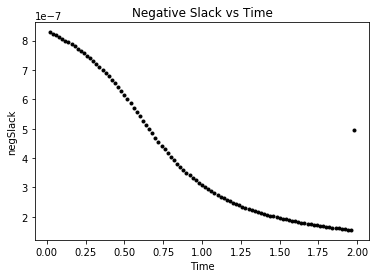

In [21]:
# Negative Slack
plt.axes()
Time = 0
for n in range (1,Nodes):
    negSlack = model.CF_neg[n].value
    time = model.h.value
    Time += time
    
    plt.plot(Time,negSlack,'k.')
    plt.xlabel('Time')
    plt.ylabel('negSlack')
    plt.title('Negative Slack vs Time')